# A Monte Carlo program for the Newman-Moore triangular lattice Ising model

In [1]:
using DelimitedFiles
using Random; Random.seed!(0);
const seed = 1234;
rng = MersenneTwister(seed);

const EqSteps = 100
const NumSteps = 1000 #Monte Carlo production steps

#k = 2
#L = 2^k
L = 65
N = L*L
Spin = fill(1,N);

In [2]:
#This is the data structure that relates up-triangles to spin indices
function make_up_triangle(L, N)
    UpTriangle = zeros(Int,N,3)
    for i = 1:N
        UpTriangle[i,1] = i
        UpTriangle[i,2] = i+1    
        UpTriangle[i,3] = i+L
        #fix PBCs
        if mod(i,L) == 0
            UpTriangle[i,2] = i + 1 - L
        end
        if (i+L)> N
            UpTriangle[i,3] = i + L - N
        end
    end
    return UpTriangle
end
UpTriangle = make_up_triangle(L, N);

In [3]:
#This is the inverse data structure that relates a spin index to its 3 up-triangles
function make_associated_tri(L, N)
    AssociatedTri = zeros(Int,N,3)
    for i = 1:N
        AssociatedTri[i,1] = i
        AssociatedTri[i,2] = i-1
        AssociatedTri[i,3] = i-L
        if mod(i-1+L,L) == 0
            AssociatedTri[i,2] = i - 1 + L
        end
        if i<(L+1) 
            AssociatedTri[i,3] = i + N - L
        end
    end
    return AssociatedTri
end
AssociatedTri = make_associated_tri(L, N);

In [4]:
#here is the brute force calculation of the energy
function Energy_Total(Energy,Spin)
    Energy = 0
    for i = 1:N
        Spin1 = Spin[UpTriangle[i,1]]
        Spin2 = Spin[UpTriangle[i,2]]
        Spin3 = Spin[UpTriangle[i,3]]
        Energy += Spin1 * Spin2 * Spin3  #J = 1
        end # limit all arithmetic to integers for as long as we can
    return Energy / 2
end #Energy_Total

Energy_Total (generic function with 1 method)

In [5]:
#here is the energy DIFFERENCE calculated from the local triangular plaquettes
function Energy_Diff(Spin,spin_index)
    
    Tri1 = AssociatedTri[spin_index,1]
    Tri2 = AssociatedTri[spin_index,2]
    Tri3 = AssociatedTri[spin_index,3]

    plaquette_factor = 0
    plaquette_factor -= Spin[UpTriangle[Tri1,2]] * Spin[UpTriangle[Tri1,3]]
    plaquette_factor -= Spin[UpTriangle[Tri2,1]] * Spin[UpTriangle[Tri2,3]]
    plaquette_factor -= Spin[UpTriangle[Tri3,1]] * Spin[UpTriangle[Tri3,2]]
    
    return Spin[spin_index] * plaquette_factor
end

# Energy_Diff can only take 4 values: -3, -1, 1, 3
# BUT, the non-positive values always result in acceptance
# so we only need to cache the value of exp(-dE / T) for 2 values of dE
# we'll store these values in a tuple of length 3, and get the
# acceptance prob by indexing with dE

Energy_Diff (generic function with 1 method)

In [6]:
function MetropolisAccept(DeltaE::Int, acceptance_ratios::NTuple{3, Float64})::Bool
    if DeltaE <= 0
        return true
    else
        rnum = rand(rng)  #random number for Metropolis
        if (acceptance_ratios[DeltaE] > rnum)
            return true
        end
    end
    return false
end

MetropolisAccept (generic function with 1 method)

In [7]:
Tarr = zeros(Float64,0)  
EMC = zeros(Float64,0)  
SpecHeat = zeros(Float64,0)  
Eexact = zeros(Float64,0)
Acceptance = zeros(Float64,0) 

const autocorr_steps = 100
const data_samples = 5000
const num_autocorrs = data_samples - autocorr_steps + 1

const gamma = 0.01
const stoptime = 200
for time = 0:stoptime
#for T = 10:-0.1:0.1  #count down  
    
    print(time," ")
    T = exp(-gamma*time)
    beta = 1.0/T
    
    acceptance_ratios = (exp(-beta*1), exp(-beta*2), exp(-beta*3))

    #initialize the energy
    Energy = 0
    Energy=Energy_Total(Energy,Spin)
    #println(Energy)

    for step = 1:EqSteps
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(DeltaE, acceptance_ratios)
                Energy += DeltaE
                Spin[spin_i] *= -1
            end 
        end #i
    end #Equilibration
    
    E_avg = 0
    E2 = 0
    A_rate = 0
    for step = 1:NumSteps
        Accept = 0
        for i = 1:N  #multiple single spin flips
            spin_i = rand(1:N)
            DeltaE = Energy_Diff(Spin,spin_i)
            if MetropolisAccept(DeltaE, acceptance_ratios)
                Energy += DeltaE
                Spin[spin_i] *= -1
                Accept += 1
                end  
        end #i
        E_avg += Energy
        E2 += Energy*Energy
        A_rate += Accept/N
    end #Monte Carlo production step

    E_exact = 1/(1+exp(beta))
    Cv = E2/NumSteps - (E_avg/NumSteps)^2
    println(T," ",E_avg/NumSteps/N," ",E_exact-0.5," ",Cv/N/T/T," ",A_rate/NumSteps)
     
    push!(Tarr,T)
    push!(EMC,E_avg/NumSteps/N)
    push!(SpecHeat,Cv/(T*T*N))
    push!(Eexact,E_exact-0.5)
    push!(Acceptance,A_rate/NumSteps)
    
    #Let's write configuration files for data
    if time == stoptime
        println("Starting to get final data")        
        Tstring = first(string(T),8)
        filename = string("stewart_data/L", L, "/gamma", gamma, "_stoptime", stoptime,
            "_T", Tstring, "_seed", seed, ".dat")
        mag_filename = string("stewart_data/L", L, "/gamma", gamma, "_stoptime", stoptime,
            "_T", Tstring, "_seed", seed, "_mag.dat")
        
        autocorrs = zeros(autocorr_steps)
        Mag_array = zeros(data_samples)
        for step = 1:data_samples #configuration data files
            for i = 1:20*N  #multiple single spin flips
                spin_i = rand(1:N)
                DeltaE = Energy_Diff(Spin,spin_i)
                if MetropolisAccept(DeltaE, acceptance_ratios)
                    Energy += DeltaE
                    Spin[spin_i] *= -1
                    end 
                end #i
            Mag_array[step] = sum(Spin)

            open(filename, "a") do io
                writedlm(io, Spin' , " ")
                end # end open
            end #step 

        
        println("Writing magnetization data")
        
        # Save data with magnetizations
        open(mag_filename, "w") do io
            writedlm(io, Mag_array', " ")
            end #end open
        
    end #if stoptime

end #T

    
EMC_filename = string("stewart_data/L", L, "/gamma", gamma, "_stoptime", stoptime,
        "_seed", seed, "_energy.dat")
open(EMC_filename, "w") do io
    writedlm(io, EMC', " ")
    end #end open

0 1.0 -0.23119029585798817 -0.2310585786300049 0.1914199192899406 0.3560840236686389
1 0.9900498337491681 -0.2333230769230769 -0.2330299669032307 0.1947393881863521 0.351092781065089
2 0.9801986733067553 -0.23461420118343196 -0.2350118162075338 0.20666338116499966 0.3473928994082838
3 0.9704455335485082 -0.23717775147928993 -0.23700400723120663 0.1886857717335605 0.3418991715976334
4 0.9607894391523232 -0.23847928994082843 -0.23900641521388233 0.20836171014040275 0.3381436686390535
5 0.951229424500714 -0.24036568047337278 -0.2410189098634476 0.1783923670042051 0.33421964497041445
6 0.9417645335842487 -0.2430248520710059 -0.24304135527459575 0.19934347151927986 0.3280757396449701
7 0.9323938199059483 -0.24548284023668637 -0.24507360984918386 0.19866406686121174 0.3236276923076928
8 0.9231163463866358 -0.24734958579881655 -0.2471155262185617 0.20651883048018163 0.31894461538461505
9 0.9139311852712282 -0.24908544378698225 -0.24916695116804632 0.24064805861239855 0.31428260355029597
10 0.

81 0.4448580662229411 -0.4052551479289941 -0.4044699295088948 0.4563147355823115 0.05088142011834319
82 0.44043165450599925 -0.40627431952662724 -0.4064042004068251 0.3516190666553751 0.049333017751479274
83 0.43604928632153556 -0.4081308875739645 -0.408322186256602 0.5037727564082282 0.04747053254437868
84 0.4317105234290797 -0.4101256804733728 -0.4102235042035662 0.44506053528050366 0.0455150295857988
85 0.4274149319487267 -0.41259242603550295 -0.4121077784057653 0.4320425256386457 0.043523786982248604
86 0.4231620823177488 -0.4148350295857988 -0.4139746404176587 0.4835240926117689 0.04154343195266269
87 0.418951549247639 -0.4142239053254438 -0.41582372956939223 0.4766441791609535 0.040930177514792915
88 0.4147829116815814 -0.4189701775147929 -0.4176546933409021 0.3635185003372574 0.03771786982248519
89 0.41065575275234545 -0.4184094674556213 -0.4194671877301032 0.37719444746865594 0.037312189349112346
90 0.4065696597405991 -0.4216123076923077 -0.42126087761441716 0.35543670010859396

160 0.20189651799465538 -0.48026295857988166 -0.492987560019391 0.020123520642082116 0.0008312426035502865
161 0.1998876140751445 -0.4806125443786982 -0.4933258123831239 0.016280161290188624 0.0007386982248520644
162 0.19789869908361465 -0.4805945562130177 -0.4936510100837256 0.014007926665406168 0.0007271005917159696
163 0.1959295741269093 -0.4806776331360947 -0.49396349163990927 0.017012234417173856 0.0007013017751479221
164 0.19398004229089189 -0.48070911242603553 -0.49426359421358085 0.010454084970298523 0.0006534911242603493
165 0.1920499086207541 -0.4806224852071006 -0.4945516532790027 0.023840512389465166 0.0006260355029585747
166 0.1901389801015205 -0.48102248520710056 -0.494828002302305 0.013182693938370797 0.0005820118343195223
167 0.18824706563874677 -0.4811254437869823 -0.4950929724317374 0.013758744502865997 0.0005493491124260317
168 0.18637397603940997 -0.4811872189349113 -0.49534689219902056 0.015970294289552295 0.0005422485207100562
169 0.18451952399298926 -0.4808923076

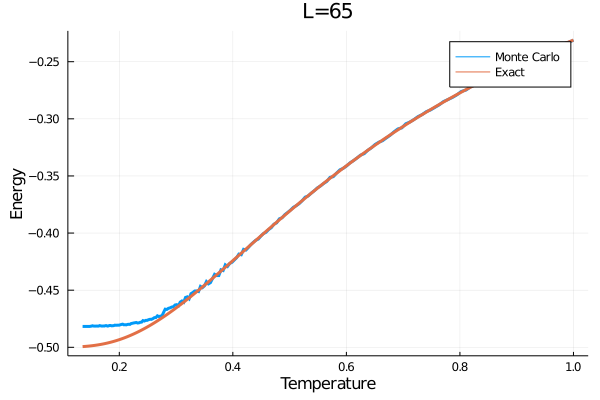

In [8]:
using Plots
Lstring = string("L=",L)
plot(Tarr, [EMC, Eexact], title = Lstring, label = ["Monte Carlo" "Exact"], lw = 3 )
xlabel!("Temperature")
ylabel!("Energy")

In [9]:
autocorr = (M_t_M_ti_avg .- M_t_avg * M_ti_avg) ./ (M_t_stdev * M_ti_stdev)
plot(1:100, autocorr, title="Magnetization Autocorrelation", label="L = 64", lw=3)
xlabel!("MC Step")
ylabel!("Autocorrelation")

UndefVarError: UndefVarError: M_t_avg not defined

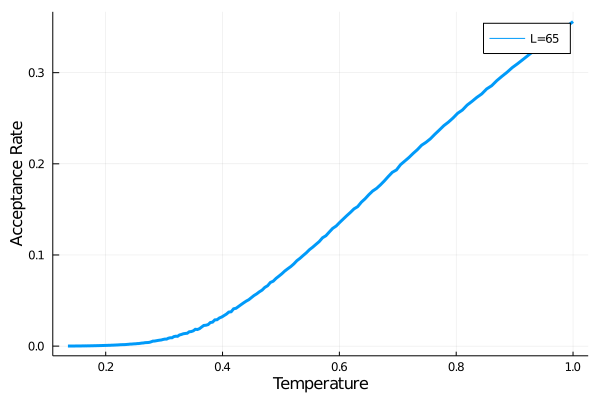

In [10]:
plot(Tarr, Acceptance, label = Lstring, lw = 3 )
xlabel!("Temperature")
ylabel!("Acceptance Rate")

In [11]:
sqrt.(fill(2,3))

3-element Array{Float64,1}:
 1.4142135623730951
 1.4142135623730951
 1.4142135623730951

In [12]:
for t = 1:0
    println(t)
end